<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/Simple_classifier_using_NNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = False
  import torch, time
  from torch import nn, optim
  from sklearn.model_selection import train_test_split
  import pandas as pd
  from sklearn.datasets import make_circles
  import matplotlib.pyplot as plt
  from torch.nn import BCEWithLogitsLoss
  from torch.utils.data import Dataset, DataLoader

  print(f">>>> You are on CoLaB with torch version: {torch.__version__}")
except Exception as e:
  COLAB = False
  print(f">>>> {type(e)}: {e}\n>>>> please correct {type(e)} and reload your drive")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"\n>>>> device: {device}")
!nvidia-smi

def __tmft__(t: float = 123.989)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t% 60)
  return f"hrs: {h} mins: {m:>02} secs: {s:>05.2f}"

print(f">>>> testing the time formating function.........\n>>>> time elapsed\t{__tmft__()}")

Mounted at /content/drive/
>>>> You are on CoLaB with torch version: 1.12.1+cu113

>>>> device: cuda
Wed Nov 23 22:03:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    14W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

In [2]:
# Load the toy dataset:
X, y = make_circles(n_samples = 10000, shuffle = True, random_state = 123, noise = 0.02)

In [3]:
# Convert to toach tensor:
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

In [4]:
print(f">>>> X shape: {X.shape}, y shape: {y.shape}")

>>>> X shape: torch.Size([10000, 2]), y shape: torch.Size([10000])


In [5]:
# Split the data into training-testing:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
 


In [6]:
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [7]:
# Vizualize the data
def __vizualizer__(X_train, X_test, Y_train, Y_test, preds = None):
  figure, axis = plt.subplots(2,2, figsize = (10, 11.5))
  axis[0,0].scatter(X_train[:, 0], X_train[:, 1], s = 4, c = Y_train, cmap = plt.cm.BrBG_r)
  axis[0,0].set_title("train data")
  axis[0, 1].scatter(X_test[:,0], X_test[:, 1], s = 4, c = Y_test, cmap = plt.cm.BrBG_r)
  axis[0,1].set_title("test data")
  if preds is not None:
    axis[1,1].scatter(X_test[:, 0], X_test[:,1], s = 4, c = preds, cmap = plt.cm.BrBG_r)
    axis[1,1].set_title("predictions")




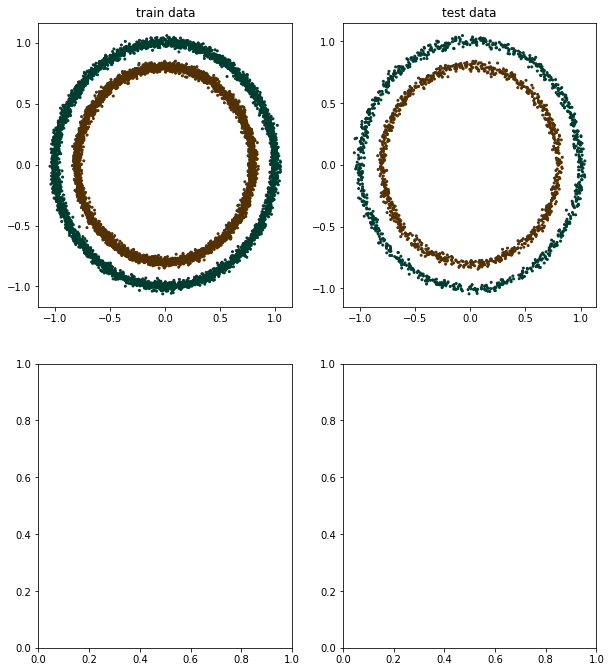

In [8]:
__vizualizer__(X_train.cpu().detach().numpy(), 
               X_test.cpu().detach().numpy(),
               Y_train.cpu().detach().numpy(),
               Y_test.cpu().detach().numpy())

* This is the hard classification proble. We can use techniques such as SVM or any non-linear 
* classifier to separate the two groups. For our case we build a simple mlp

In [9]:
class MLP_classifier(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.mlp = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.BatchNorm1d(num_features = self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, self.hidden_dim),
        nn.BatchNorm1d(num_features = self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, 1)
    )
  
  def forward(self, input:torch.Tensor)->torch.Tensor:
    return self.mlp(input)

In [10]:
# Instantiating the model and get predictions for the untrained classifier

In [11]:
input_dim = 2
hidden_dim = 64
mlp = MLP_classifier(input_dim, hidden_dim)
x = torch.randn(size = (32,2), device = device)
mlp.to(device = device)
assert mlp(x).shape == (32,1)

In [12]:
print(mlp)

MLP_classifier(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [13]:
mlp.eval()
with torch.inference_mode():
  predictions = mlp(X_test)

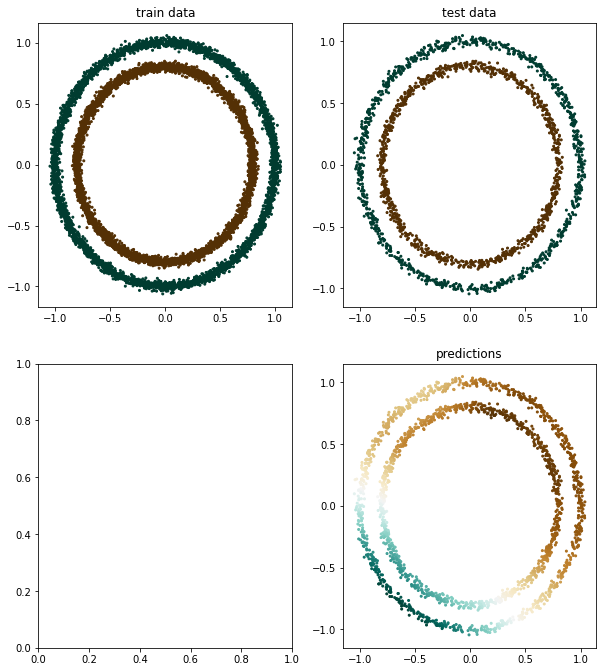

In [14]:
__vizualizer__(X_train.cpu().detach().numpy(),
               X_test.cpu().detach().numpy(), 
               Y_train.cpu().detach().numpy(), 
               Y_test.cpu().detach().numpy(), 
               predictions.cpu().detach().numpy())

From the plot we see the predictions are randomly assigned by our untrained network.

**To really see the performance for our simple classifier lets compute the accuracy [proportional of
samples which are correctly classified among the total test examples]

In [15]:
def model_accuracy(labels, preds):
  preds = torch.round(torch.sigmoid(preds)).squeeze()
  acc = torch.eq(preds, labels).sum().item()
  return f"{acc/len(labels):.2f}"

In [16]:
acc = model_accuracy(Y_test.to(device = device), predictions)

In [17]:
print(f">>>> The accuracy of our untrained network is {acc}")

>>>> The accuracy of our untrained network is 0.49


In [18]:
# Lets build the customized PyTorch iterator for our dataset:
class MyDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = X
    self.Y = Y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    X = self.X[idx]
    Y = self.Y[idx]
    return X, Y

In [19]:
train_data = MyDataset(X_train, Y_train)
test_data = MyDataset(X_test, Y_test)
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = 32)


In [20]:
x_train, y_train = next(iter(train_loader))
print(f">>>> train batch shape: {x_train.shape, y_train.unsqueeze(1).shape}")

>>>> train batch shape: (torch.Size([32, 2]), torch.Size([32, 1]))


In [21]:
optimizer = optim.SGD(params = mlp.parameters(), lr = 1e-3)
criterion = BCEWithLogitsLoss()


In [22]:
def train_val_loader(train_loader,
                     test_loader,
                     model, criterion,
                     optimizer, EPOCHS):
  
  print(f">>>> training starts: Please wait......................................")
  train_loss_per_epoch = 0
  val_loss_per_epoch = 0
  #model.to(device = device)
  #model.cuda()
  model.train()
  train_acc_per_epoch = 0
  val_acc_per_epoch = 0
  for epoch in range(EPOCHS):
    #print(f"\n>>>> training starts for epoch {epoch}")
    for idx, (data, labels) in enumerate(train_loader):
      data = data.to(device) 
      labels = labels.to(device)
      #model.to(device = device)

      logits = model(data)
      optimizer.zero_grad()
      train_loss = criterion(logits, labels.unsqueeze(1))
      train_loss.backward()
      optimizer.step()
      train_loss_per_epoch+= train_loss
      train_acc = model_accuracy(labels, logits)
      train_acc_per_epoch+= float(train_acc)
    
    if epoch % 100 == 0:
      print(f"\n>>>> end of training for epoch {epoch}: \
      \n>>>> Average train loss: {train_loss_per_epoch/len(train_loader):.4f}\
      \n>>>> Average train accuracy: {train_acc_per_epoch/len(train_loader):.2f} ")
    
    model.eval()
    with torch.inference_mode():
      for idx, (data, labels) in enumerate(test_loader):
        data.to(device), labels.to(device)

        logits = model(data)
        test_loss = criterion(logits, labels.unsqueeze(1))
        val_loss_per_epoch+=test_loss
        val_acc = model_accuracy(labels, logits)
        val_acc_per_epoch+=float(val_acc)
      
      if epoch % 100 == 0:
        print(f"\n>>>> end of validation for epoch {epoch}:\
        \n>>>> average validation loss: {val_loss_per_epoch/len(test_loader):.4f}\
        \n>>>> average validation accuracy: {val_acc_per_epoch/len(test_loader):.2f}")


    

    
    
  

In [23]:
# Lets now train our classifier
tic = time.time()
train_val_loader(train_loader, test_loader, mlp, criterion, optimizer, 101)
toc = time.time()
print(f"\n>>>> time elapsed after training for 100 Epochs: {__tmft__(toc - tic)}")

>>>> training starts: Please wait......................................

>>>> end of training for epoch 0:       
>>>> Average train loss: 0.6895      
>>>> Average train accuracy: 0.49 

>>>> end of validation for epoch 0:        
>>>> average validation loss: 0.6691        
>>>> average validation accuracy: 0.51

>>>> end of training for epoch 100:       
>>>> Average train loss: 4.9803      
>>>> Average train accuracy: 99.51 

>>>> end of validation for epoch 100:        
>>>> average validation loss: 4.6424        
>>>> average validation accuracy: 99.69

>>>> time elapsed after training for 100 Epochs: hrs: 0 mins: 00 secs: 50.00


In [24]:
# We can compute the predictions for the trained classifier and plot the results 
# to see any change

In [25]:
mlp.eval()
with torch.inference_mode():
  preds = mlp(X_test)
  

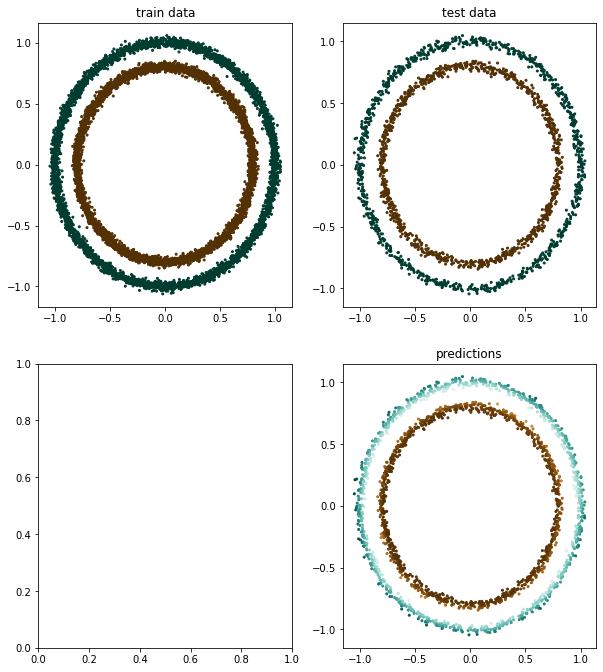

In [26]:
__vizualizer__(X_train.cpu().detach().numpy(),
               X_test.cpu().detach().numpy(),
               Y_train.cpu().detach().numpy(),
               Y_test.cpu().detach().numpy(),
               preds.cpu().detach().numpy())

In [27]:
# Note: The parten for the prediction circle looks more like the rest of the data.===> well classified
# with the accuracy of 99%. 